In [48]:
# lists all packages needed in this notebook
packages_list = list('ggplot2', 'corrplot', 'glmnet', 'lars', 'tidyverse',
                  'ggplot2', 'gglasso', 'caret', 'here', 'car', 'grpreg', 'scales', 'olsrr', 'plm', 'dplyr')
# checks to see if package is installed.  If not, installs and loads it
for (i in packages_list) {
  if (!require(i, character.only=TRUE)) install.packages(i, character.only=TRUE); library(i, character.only=TRUE)
}
# Set colors
gtblue = rgb(0, 48, 87, maxColorValue = 255)
techgold = rgb(179, 163, 105, maxColorValue = 255)
buzzgold = rgb(234, 190, 0, maxColorValue = 255)
bobbyjones = rgb(55, 113, 23, maxColorValue = 255)

In [49]:
#read in the data file
House <- read.csv("everything.csv", header=TRUE)
head(House)

,RegionID,SizeRank,RegionName,RegionType,date,ZHVI,year_month,CPI,Mortgage_rate,Unemp_rate,⋯,Sheltered.Total.Homeless.People.in.Families...Age.35.to.44,Sheltered.Total.Homeless.People.in.Families...Age.45.to.54,Sheltered.Total.Homeless.People.in.Families...Age.55.to.64,Sheltered.Total.Homeless.People.in.Families...Over.64,Unsheltered.Homeless.People.in.Families...Age.25.to.34,Unsheltered.Homeless.People.in.Families...Age.35.to.44,Unsheltered.Homeless.People.in.Families...Age.45.to.54,Unsheltered.Homeless.People.in.Families...Age.55.to.64,Unsheltered.Homeless.People.in.Families...Over.64,CPI_Rent
,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,3,48,AK,state,2000-01-31,135030.8,2000-01,169.3,8.2100,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,196.0
2,3,48,AK,state,2000-02-29,135184.2,2000-02,170.0,8.3250,4.1,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,196.5
3,3,48,AK,state,2000-03-31,135337.5,2000-03,171.0,8.2400,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,196.9
4,3,48,AK,state,2000-04-30,135517.3,2000-04,170.9,8.1525,3.8,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,197.3
5,3,48,AK,state,2000-05-31,135787.9,2000-05,171.2,8.5150,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,197.8
6,3,48,AK,state,2000-06-30,135990.2,2000-06,172.2,8.2880,4.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,198.4


In [50]:
#Convert appropriate fields 
dataHouse <- House
dataHouse$Overall.Homeless = as.numeric(dataHouse$Overall.Homeless)
dataHouse$Sheltered.ES.Homeless = as.numeric(dataHouse$Sheltered.ES.Homeless)
dataHouse$Sheltered.TH.Homeless = as.numeric(dataHouse$Sheltered.TH.Homeless)
dataHouse$Sheltered.Total.Homeless = as.numeric(dataHouse$Sheltered.Total.Homeless)
dataHouse$Unsheltered.Homeless = as.numeric(dataHouse$Unsheltered.Homeless)
dataHouse$Sheltered.SH.Homeless = as.numeric(dataHouse$Sheltered.SH.Homeless)
dataHouse$CPI_Rent = as.numeric(dataHouse$CPI_Rent)
dataHouse$ZHVI_adj = as.numeric(House$ZHVI/1000)
# Convert date to Date format
dataHouse$date <- as.Date(dataHouse$date, format="%Y-%m-%d")
# Convert RegionName to factor:
dataHouse$RegionName <- as.factor(dataHouse$RegionName)

head(dataHouse, 1)

,RegionID,SizeRank,RegionName,RegionType,date,ZHVI,year_month,CPI,Mortgage_rate,Unemp_rate,⋯,Sheltered.Total.Homeless.People.in.Families...Age.45.to.54,Sheltered.Total.Homeless.People.in.Families...Age.55.to.64,Sheltered.Total.Homeless.People.in.Families...Over.64,Unsheltered.Homeless.People.in.Families...Age.25.to.34,Unsheltered.Homeless.People.in.Families...Age.35.to.44,Unsheltered.Homeless.People.in.Families...Age.45.to.54,Unsheltered.Homeless.People.in.Families...Age.55.to.64,Unsheltered.Homeless.People.in.Families...Over.64,CPI_Rent,ZHVI_adj
,<int>,<int>,<fct>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,3,48,AK,state,2000-01-31,135030.8,2000-01,169.3,8.21,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,196,135.0308


There are 15402 observations in the data

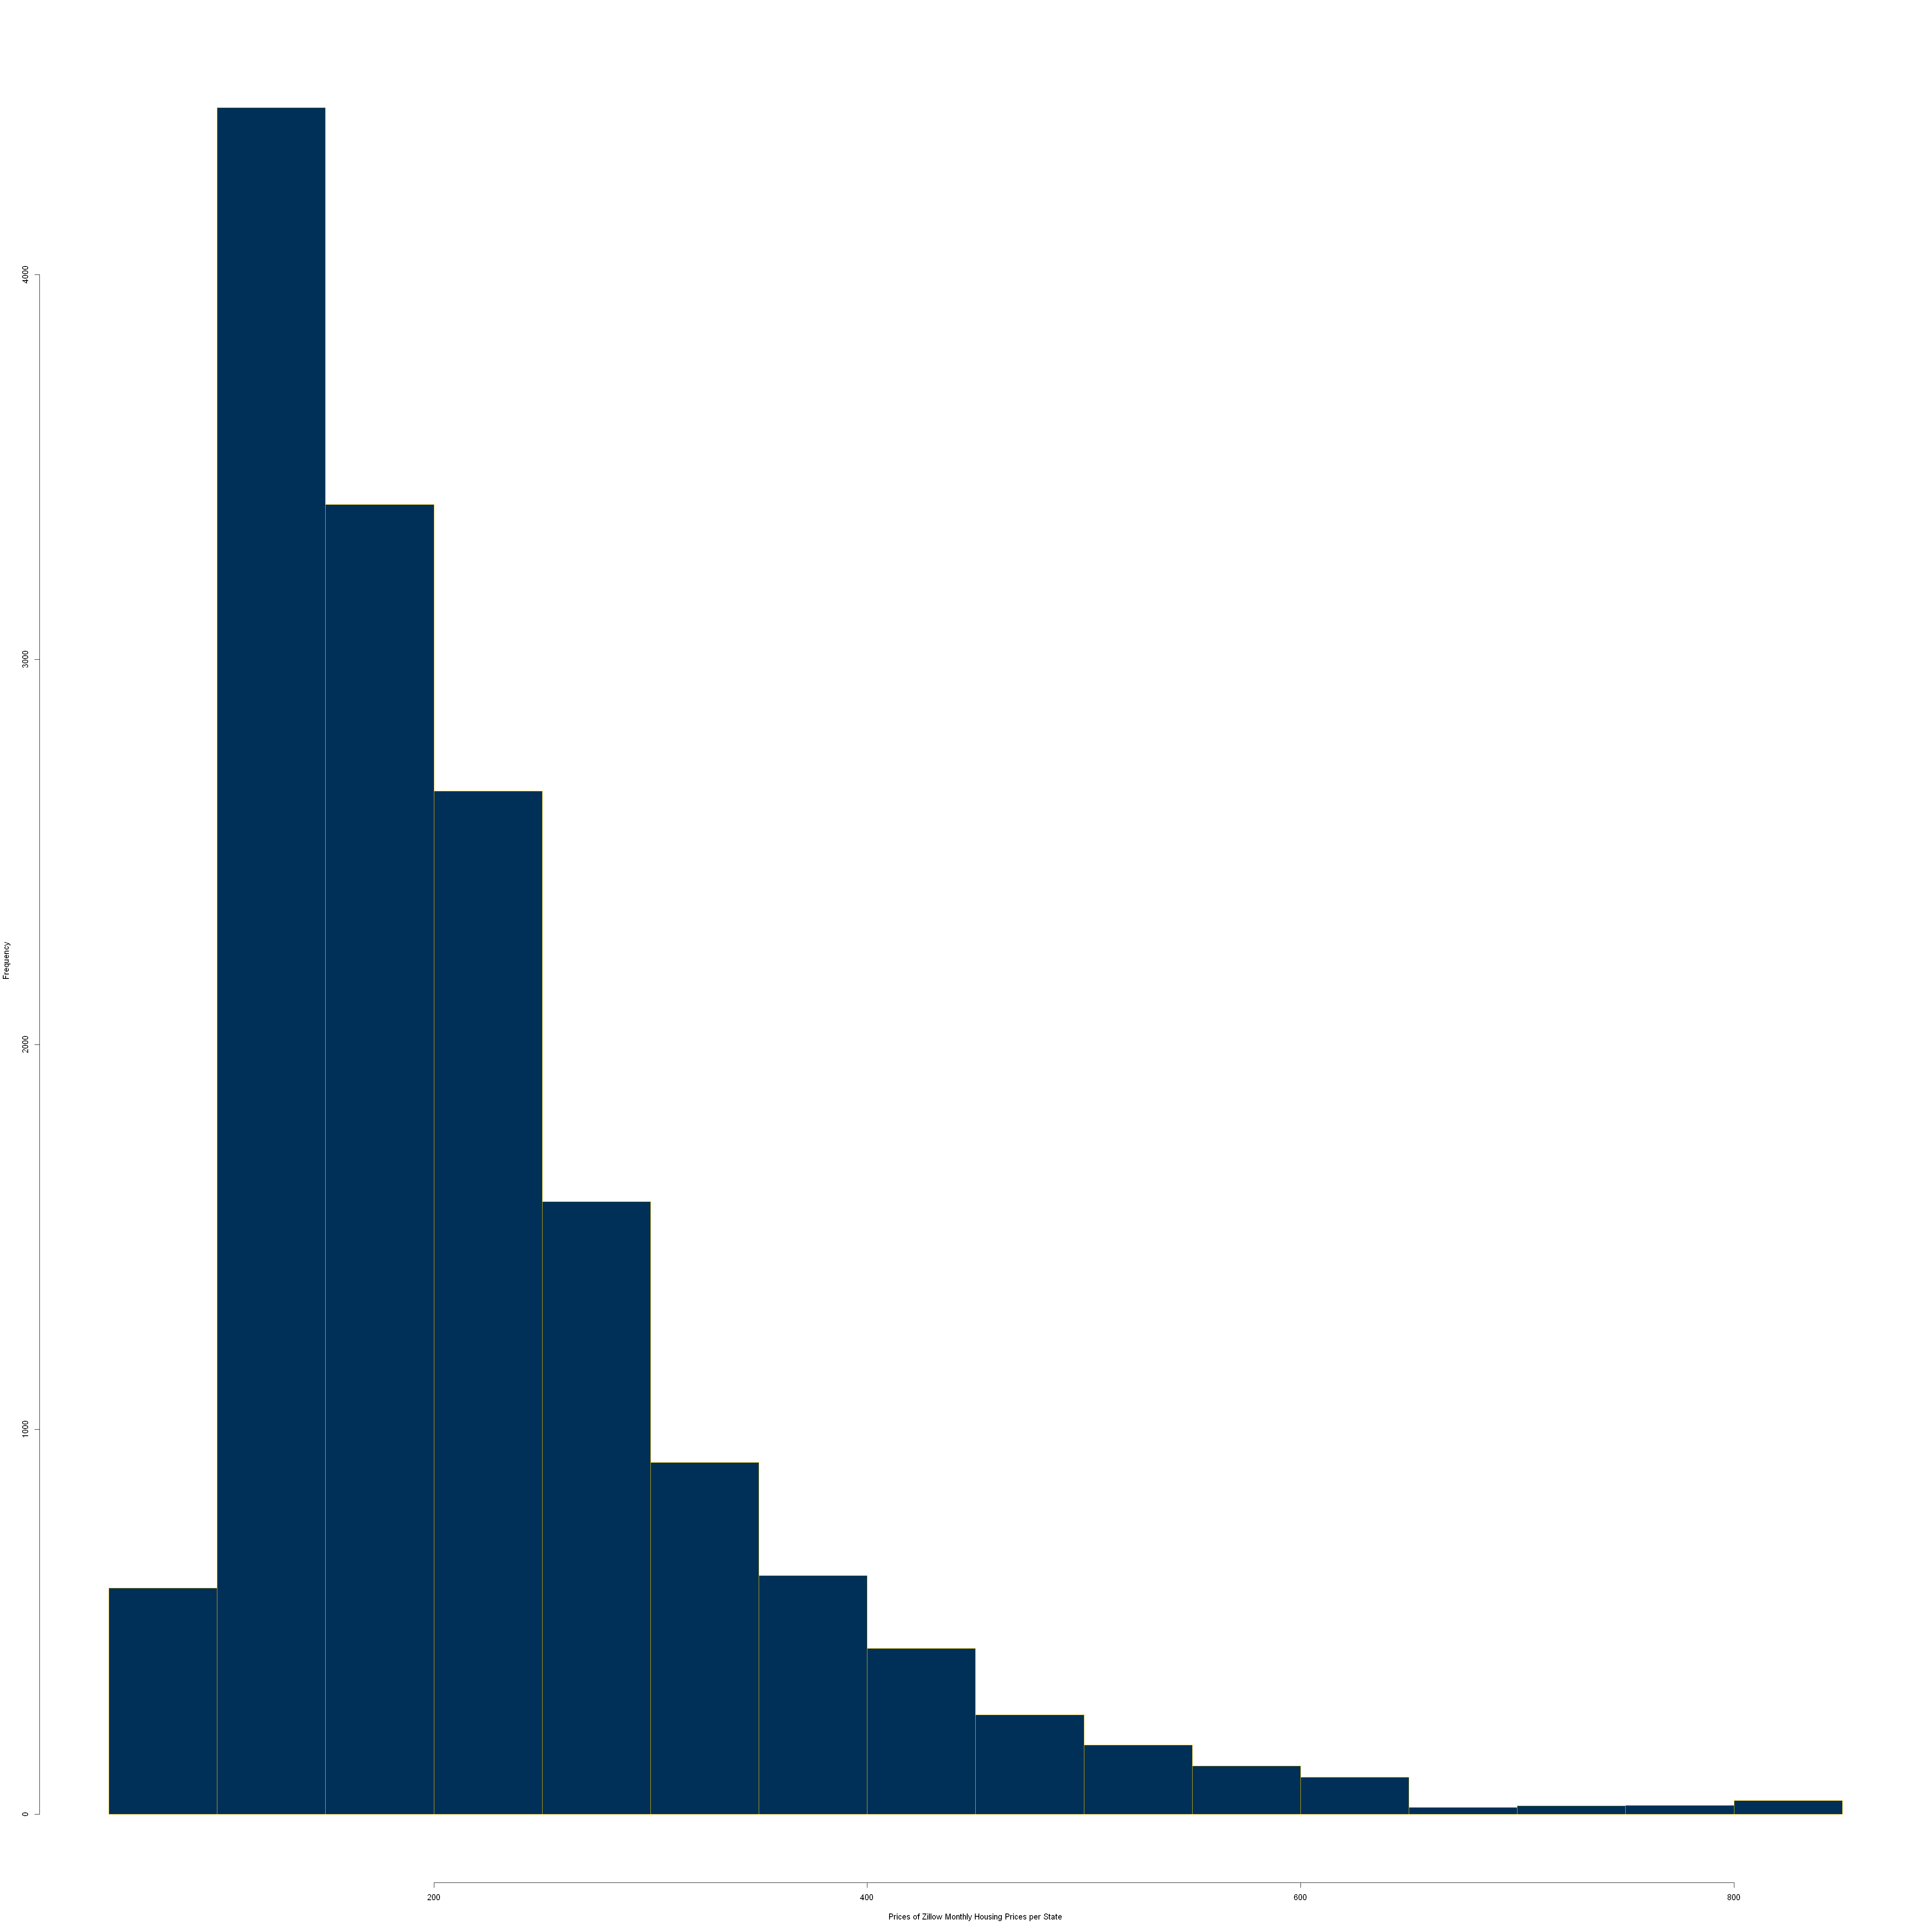

In [51]:
# Show the number of observations
obs = nrow(dataHouse)
cat("There are", obs, "observations in the data")

### Response Data Distribution

# Check the distribution of the response, cnt
hist(dataHouse$ZHVI_adj,
     main="",
     xlab="Prices of Zillow Monthly Housing Prices per State", #need to find index value: $, thousands of $, etc
     border=buzzgold,
     col=gtblue)


In [52]:
df <- dataHouse %>%
group_by(year_month) %>%
summarize(avg_ZHVI_adj = mean(ZHVI_adj, na.rm = TRUE))

head(df)

year_month,avg_ZHVI_adj
<chr>,<dbl>
2000-01,123.3923
2000-02,124.1248
2000-03,123.8456
2000-04,123.5607
2000-05,124.9993
2000-06,126.1956


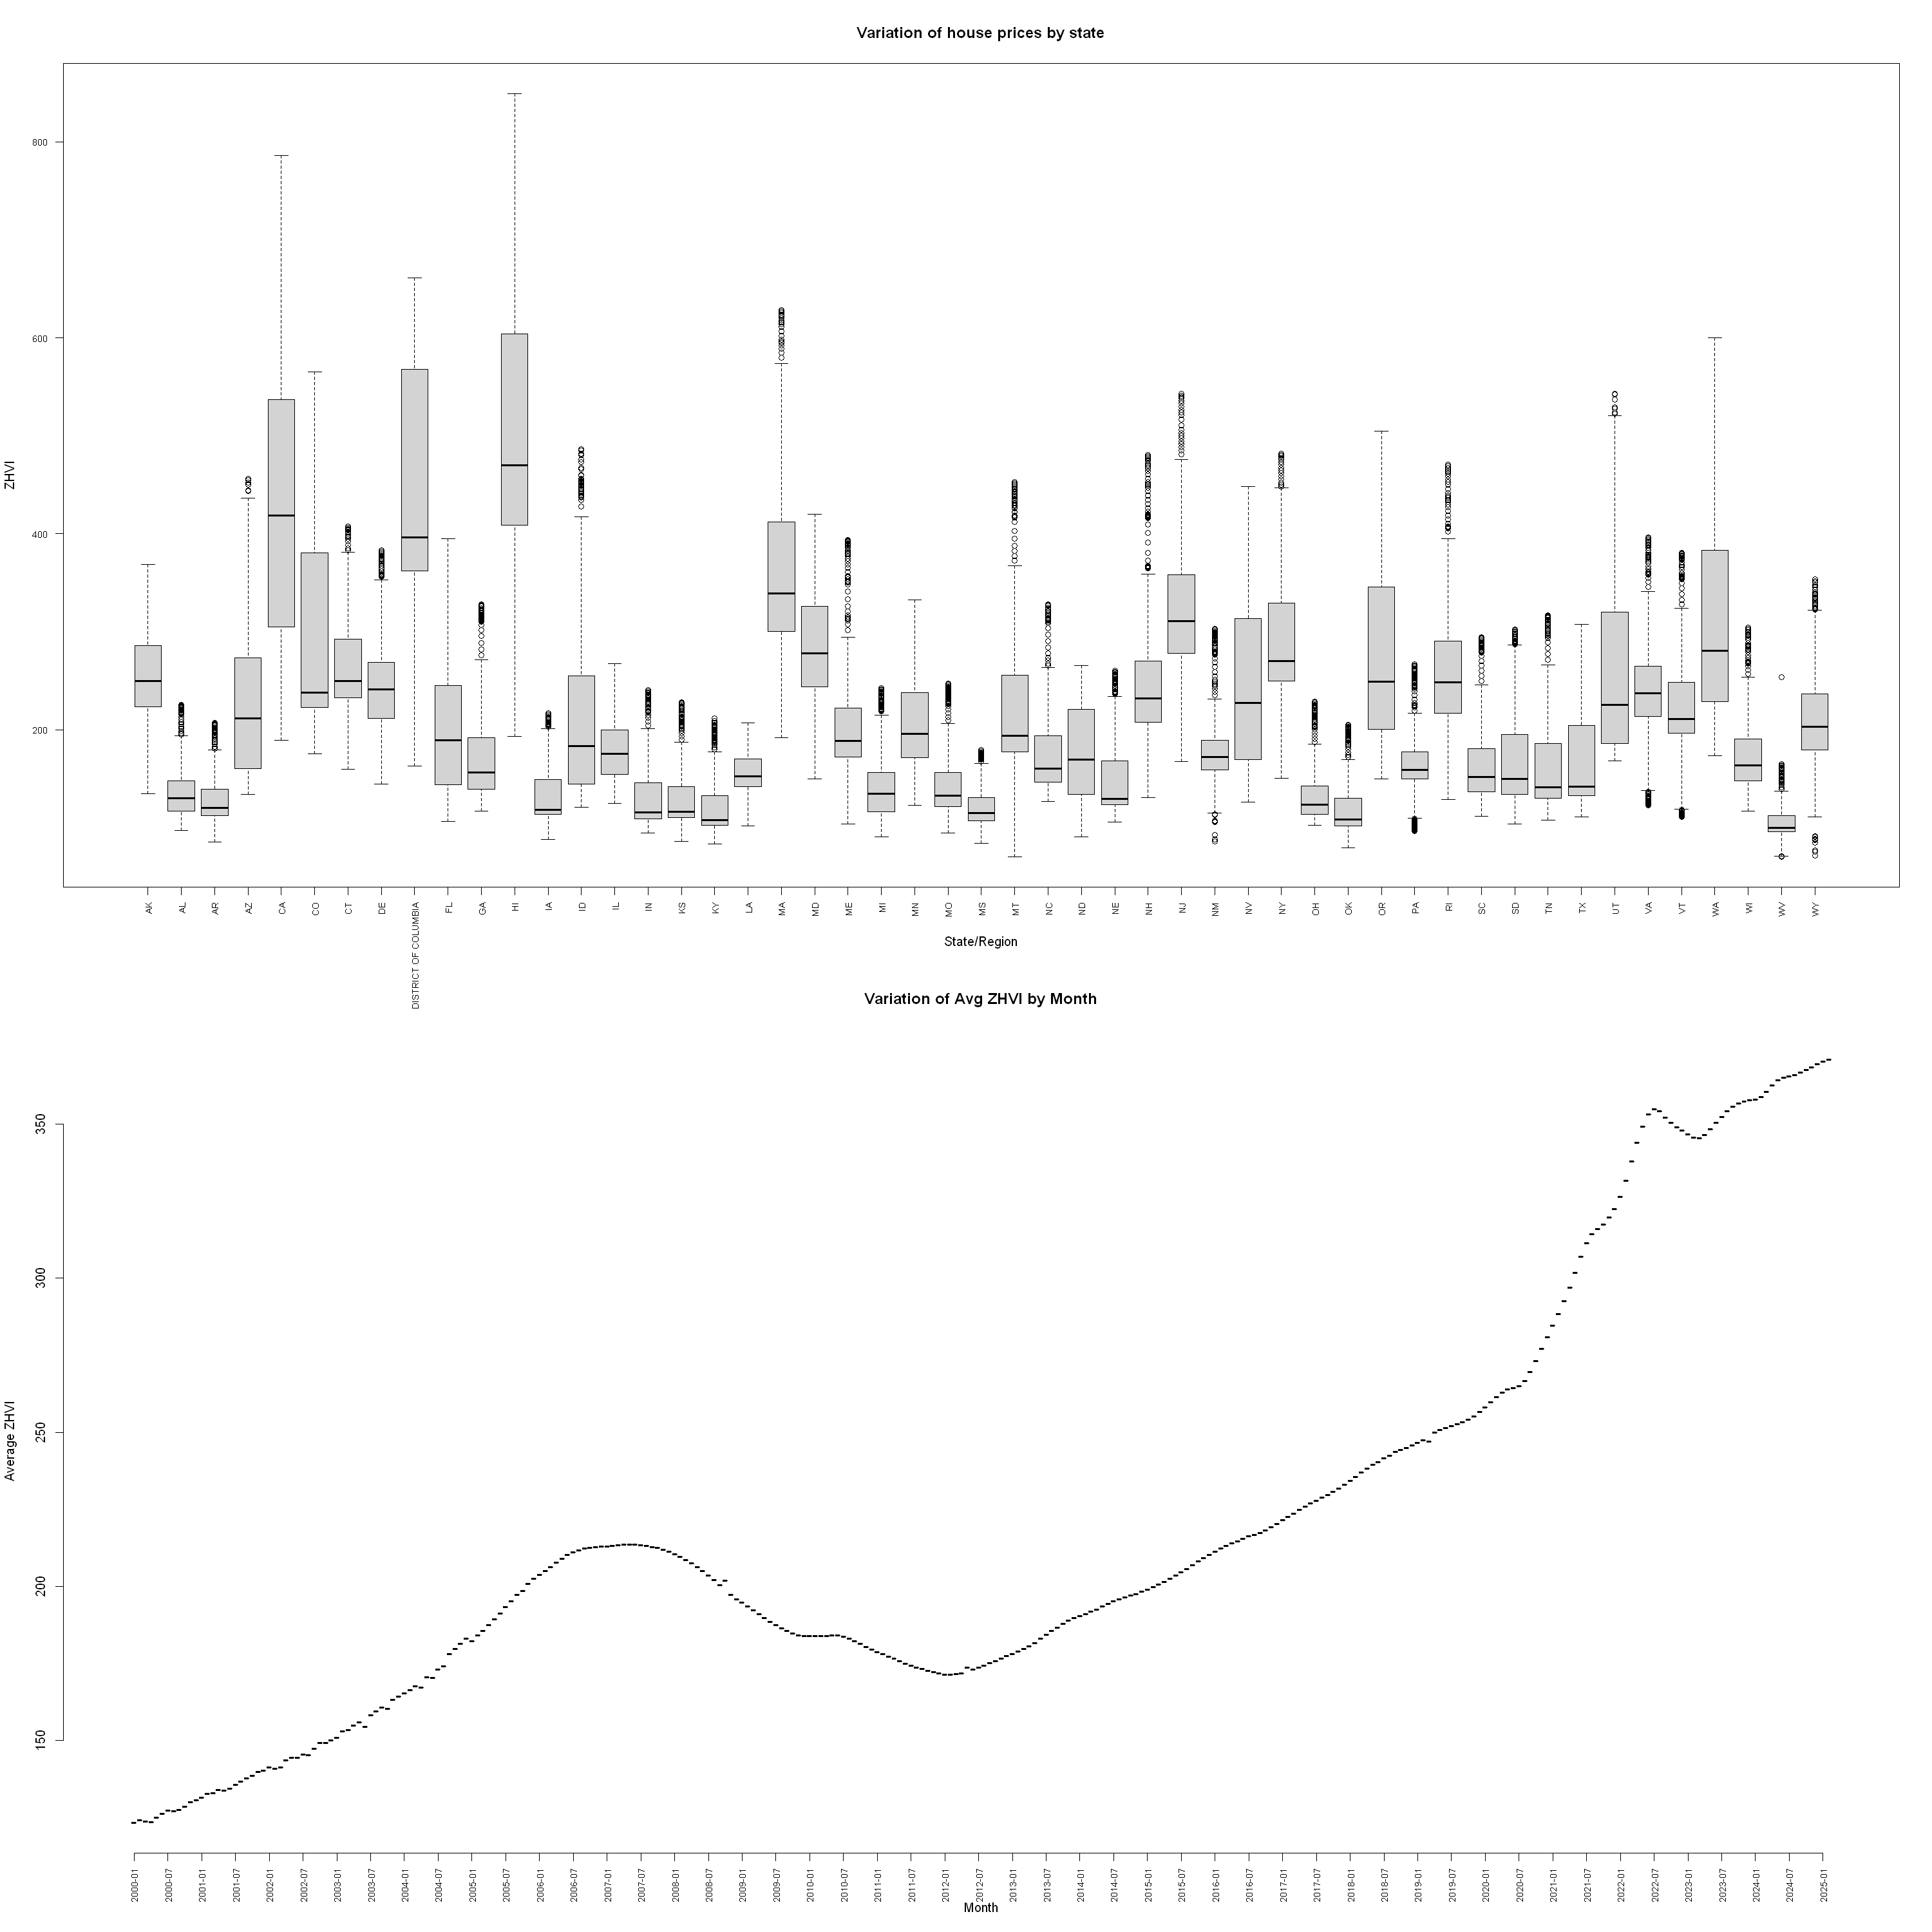

In [53]:
# Response variable vs categorical prediciting variables
options(repr.plot.width = 25, repr.plot.height = 25)
par(mfrow = c(2,1))

# Plot ZHVI variation across states
boxplot(ZHVI_adj ~ RegionName, data = dataHouse,
        main = "Variation of house prices by state",
        xlab = "State/Region", ylab = "ZHVI", las = 2, cex.axis = 0.7)

# If df is a summarized version of dataHouse with monthly averages
# Make sure df is created properly, e.g., using dplyr::group_by()
boxplot(avg_ZHVI_adj ~ year_month, data = df, main = "Variation of Avg ZHVI by Month", xlab = "Month", ylab = "Average ZHVI", axes = FALSE)
axis(2)
x_6m <- seq(1, length(unique(df$year_month)), by = 6)  # Every 6 months
axis(1, at = x_6m, labels = unique(df$year_month)[x_6m], las = 2, cex.axis = 0.7)

options(repr.plot.width = 10, repr.plot.height = 8)


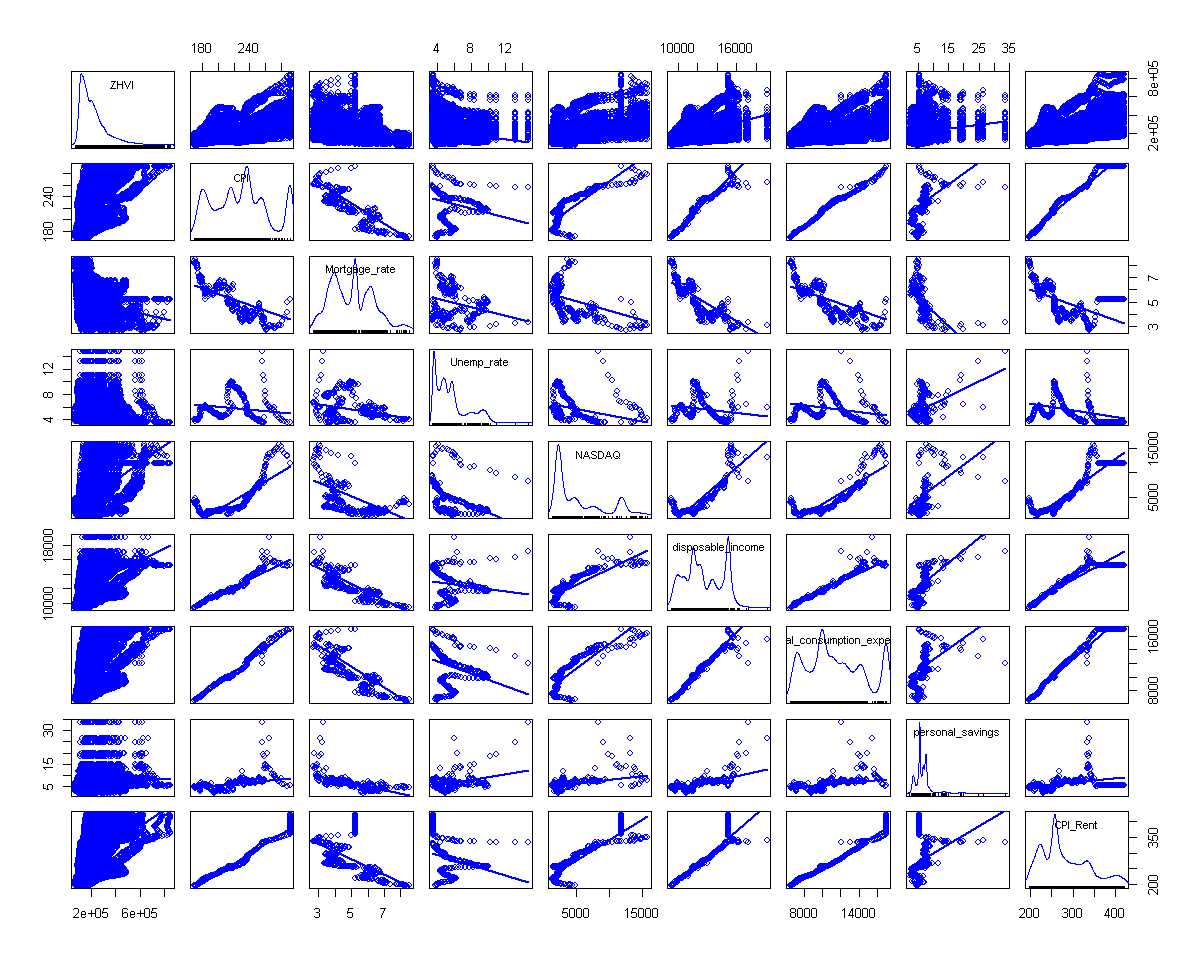

In [54]:
# Scatterplot matrix plots
par(mfrow=c(1,1))

# Response vs Key economic indicator and short term rental CPI
scatterplotMatrix(~ ZHVI + CPI + Mortgage_rate + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings + CPI_Rent, data=dataHouse, smooth=FALSE)

In [55]:
#Pulled from approach 2, we get the clean homelessness data:
# https://stackoverflow.com/questions/52221044/dplyrfirst-to-choose-first-non-na-value
df_hl <- dataHouse %>%
group_by(RegionName, date) %>%
summarize(
    avg_ZHVI = mean(ZHVI, na.rm = TRUE),

    Overall.Homeless = first(na.omit(Overall.Homeless)),
    Sheltered.ES.Homeless = first(na.omit(Sheltered.ES.Homeless)),
    Sheltered.TH.Homeless = first(na.omit(Sheltered.TH.Homeless)),
    Sheltered.Total.Homeless = first(na.omit(Sheltered.Total.Homeless)),
    Unsheltered.Homeless = first(na.omit(Unsheltered.Homeless)),
    Sheltered.SH.Homeless = first(na.omit(Sheltered.SH.Homeless)),

    .groups = 'drop'
    )

# make sheltered into a categorical variable
homeless_df <- df_hl %>%
pivot_longer(cols = c(Sheltered.ES.Homeless, Sheltered.TH.Homeless, Sheltered.SH.Homeless, Unsheltered.Homeless),
             names_to = 'Sheltered.Type',
             values_to = 'Sheltered.Type.Count')
# https://stackoverflow.com/questions/66736264/how-do-i-rename-values-of-a-variable-in-r
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.ES.Homeless'] = 'ES'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.TH.Homeless'] = 'TH'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.SH.Homeless'] = 'SH'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Unsheltered.Homeless'] = 'US'

homeless_df$Sheltered.Type <- as.factor(homeless_df$Sheltered.Type)

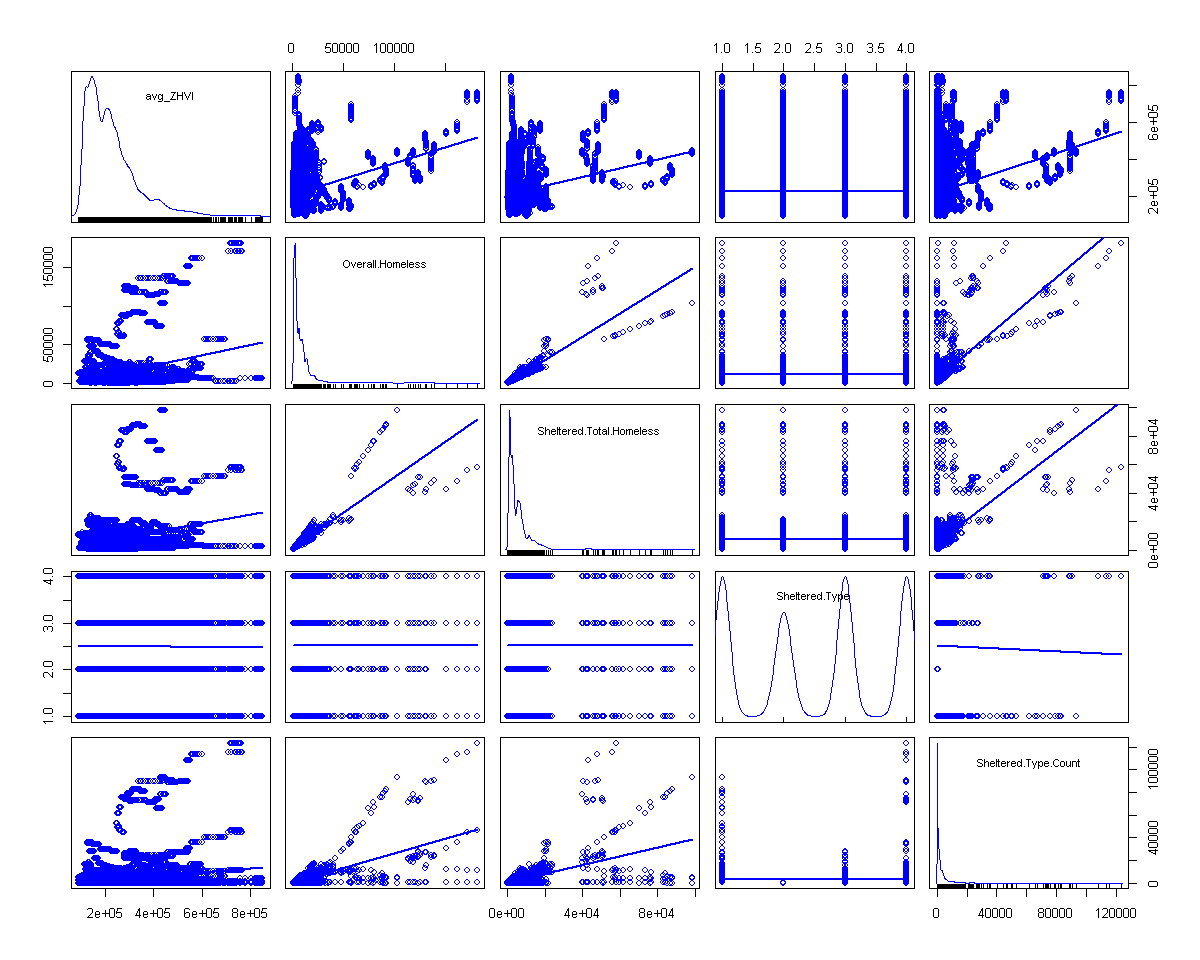

In [56]:
# Response vs Homelessness variables
scatterplotMatrix(~ avg_ZHVI + Overall.Homeless+Sheltered.Total.Homeless+Sheltered.Type+Sheltered.Type.Count, data=homeless_df, smooth=FALSE)

In [ ]:
dataModel <- dataHouse[,c(3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23, 25, 26, 27, 28, 29, 53, 684)]
head(dataModel,1)

In [ ]:
dataModel <- dataHouse[,c(3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23, 25, 26, 27, 28, 29, 53, 684)]
dataModel <- dataModel[complete.cases(dataModel), ]
# Taken from Approach 1 and elaborated to include new variables. 

dataModel_clean <- dataModel[sapply(dataModel, is.numeric)]
dataModel_clean <- dataModel_clean[, -c(9)]
head(dataModel_clean,1)
# comput a correlation matrix
cor_matrix <- cor(dataModel_clean, use = "complete.obs", method = "pearson")

corrplot(cor_matrix, method = "circle")

In [ ]:
#Setup training split
trainData <- dataModel[dataModel$Year != '2023', ]
testData <- dataModel[dataModel$Year == '2023', ]

nrow(dataHouse)
nrow(dataModel)
nrow(trainData)
nrow(testData)
head(dataModel,1)

In [ ]:
## Creating the Models
# Create a multiple linear regression model (homeless fields based on model4 of approach2)
model_MR = lm(ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent,
            data=trainData)
summary(model_MR)

In [ ]:
### Finding Insignificant Variables
as.data.frame(which(summary(model_MR)$coeff[,4]>0.05))

In [ ]:
### This is Panel Data so lets also look at a panel data model:
#Step 1: represent data as panel data:
dataPanel <- dataModel

# Convert data frame to panel data frame
dataPanel <- pdata.frame(dataPanel, index = c("RegionName", "date"))
head(dataPanel, 1)

In [ ]:
#Create models with different effects - Fixed Effect (within)
model_Pfe <- plm(ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
                data = dataPanel, model = "within")
summary(model_Pfe)

In [ ]:
### Finding Insignificant Variables
as.data.frame(which(summary(model_Pfe)$coeff[,4]>0.05))

In [ ]:
#Create models with different effects - Pooled OLS which should yield similar results as normal reg
model_Pp <- plm(ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
                data = dataPanel, model = "pooling")
summary(model_Pp)

In [ ]:
### Finding Insignificant Variables
as.data.frame(which(summary(model_Pp)$coeff[,4]>0.05))

In [ ]:
## Model Assessment: Multiple reg

### Constant Variance Assumption
# Extract the standardized residuals
residsMR = rstandard(model_MR)
fitsMR = model_MR$fitted

# Plot the standardized residuals against
# fitted values
plot(fitsMR, residsMR,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

In [ ]:
#Use box Cox to evaluate if Response should be transformed:
bc = boxCox(model_MR)
opt.lambda = bc$x[which.max(bc$y)]
cat('Optimal lambda: ', round(opt.lambda/0.5) * 0.5, '\n')

The constant variance assumption does not hold --  the variance increases when moving from lower to higher fitted values. This can be refered to as megaphoning.Therefore, we use the BoxCox statistic to evaluate how we should transform our sdata. The lambda is rounded to -0.5 (so taking as zero). Therefore, a regression of the response logged will be tested.


In [ ]:
model_MR2 = lm(log(ZHVI) ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent,
            data=trainData)
summary(model_MR2)

In [ ]:
## Model Assessment: Multiple reg

### Constant Variance Assumption
# Extract the standardized residuals
residsMR2 = rstandard(model_MR2)
fitsMR2 = model_MR2$fitted

# Plot the standardized residuals against
# fitted values
plot(fitsMR2, residsMR2,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

In [ ]:
### Linearity Assumption
par(mfrow=c(4,4))
options(repr.plot.width = 25, repr.plot.height = 25)

# Plot the standardized residuals against numeric variables

plot(trainData$Mortgage_rate, residsMR2,
     xlab="Mortgage Rate",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Unemp_rate, residsMR2,
     xlab="Unemployment",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$NASDAQ, residsMR2,
     xlab="NASDAQ",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$disposable_income, residsMR2,
     xlab="Disposable Income",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Personal_consumption_expenditure, residsMR2,
     xlab="Personal Costs",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$personal_savings, residsMR2,
     xlab="Personal Saving",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Overall.Homeless, residsMR2,
     xlab="Overall Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.ES.Homeless, residsMR2,
     xlab="Sheltered.ES.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.TH.Homeless, residsMR2,
     xlab="Sheltered.TH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.Total.Homeless, residsMR2,
     xlab="Sheltered.Total.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Unsheltered.Homeless, residsMR2,
     xlab="Unsheltered.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.SH.Homeless, residsMR2,
     xlab="Sheltered.SH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$CPI_Rent, residsMR2,
     xlab="CPI for Rent",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

In [ ]:
### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(residsMR2,
     nclass=20,
     col=gtblue,
     border=techgold,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(residsMR2, envelope = 0.95)

We have outliers to deal with it seems.

In [ ]:
## Goodness of Fit
# Calculate Cook's distances
modelMR_cook <- cooks.distance(model_MR2)

# Get the number of rows in the dataset used to create the model
cook_n <- nrow(model_MR2$model)

# Calculate threshold
cook_threshold <- 4 / cook_n

# Plot Cook's distances
plot(modelMR_cook, main = "Cook's Distance", ylab = "Cook's Distance", xlab = "Observation")
abline(h = cook_threshold, col = "red", lty = 2)

# Print the calculated threshold
print(paste("Cook's distance threshold:", cook_threshold))

# Identify outliers
outliers <- which(modelMR_cook > cook_threshold)

# Print the number of outliers
print(paste("Number of outliers:", length(outliers)))

# Output the highest 5 outlier rows from train_sales_data
highest_outliers <- order(modelMR_cook[outliers], decreasing = TRUE)[1:5]
outlier_rows <- trainData[outliers[highest_outliers], ]


In [ ]:
outlier_year <- trainData[outliers, ] %>%
                group_by(Year) %>%
                summarise(outlier_count = n()) %>%
                arrange(Year)
outlier_year

Potential outliers because of GFC and Covid

In [ ]:
#Run reg without outliers:
trainData_cook <- trainData[-outliers, ]
model_MR2_cook = lm(log(ZHVI) ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent,
            data=trainData_cook)
summary(model_MR2_cook)

In [ ]:
## Constant Variance Assumption
# Extract the standardized residuals
residsMR2c = rstandard(model_MR2_cook)
fitsMR2c = model_MR2_cook$fitted

# Plot the standardized residuals against fitted values
plot(fitsMR2c, residsMR2c,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(residsMR2c,
     nclass=20,
     col=gtblue,
     border=techgold,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(residsMR2c, envelope = 0.95)

In [ ]:
### Finding Insignificant Variables
as.data.frame(which(summary(model_MR2_cook)$coeff[,4]>0.05))

In [ ]:
#Multicollinearity
round(vif(model_MR2_cook),3)

Going to reduce the model down to one Homeless field as all linked (focus on Homeless unsheltered), drop CPI as CPI includes CPI rent as well as personal_saving as not significant. Will also look to dop Personal_consumption_expenditure and disposable-income as they all move in the same direction and are heavily linked as a better performing market typically indicates a better performing economy whihc ties back to more diposable income and hence more spending.

In [57]:
model_MR2_vif = lm(log(ZHVI) ~ RegionName + Mortgage_rate + Unemp_rate + NASDAQ + Unsheltered.Homeless + CPI_Rent,
            data=trainData_cook)
summary(model_MR2_vif)


Call:
lm(formula = log(ZHVI) ~ RegionName + Mortgage_rate + Unemp_rate + 
    NASDAQ + Unsheltered.Homeless + CPI_Rent, data = trainData_cook)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.230673 -0.036916 -0.000041  0.038957  0.215458 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           1.113e+01  2.144e-02  519.344  < 2e-16 ***
RegionNameAL         -6.886e-01  7.094e-03  -97.069  < 2e-16 ***
RegionNameAR         -7.544e-01  7.094e-03 -106.348  < 2e-16 ***
RegionNameAZ         -2.465e-01  7.767e-03  -31.730  < 2e-16 ***
RegionNameCA          4.778e-01  1.915e-02   24.952  < 2e-16 ***
RegionNameCO          1.181e-01  7.439e-03   15.880  < 2e-16 ***
RegionNameCT         -1.390e-01  7.352e-03  -18.909  < 2e-16 ***
RegionNameDE         -1.335e-01  7.090e-03  -18.825  < 2e-16 ***
RegionNameFL         -3.637e-01  8.420e-03  -43.188  < 2e-16 ***
RegionNameGA         -5.318e-01  7.333e-03  -72.526  < 2e-16 ***
RegionNameHI

In [58]:
#Multicollinearity
round(vif(model_MR2_vif),3)

,GVIF,Df,GVIF^(1/(2*Df))
RegionName,12.936,49,1.026
Mortgage_rate,1.329,1,1.153
Unemp_rate,1.743,1,1.320
NASDAQ,11.861,1,3.444
Unsheltered.Homeless,12.756,1,3.572
CPI_Rent,12.821,1,3.581


In [ ]:
## Model Assessment: Multiple reg

### Constant Variance Assumption
# Extract the standardized residuals
residsMR_vif = rstandard(model_MR2_vif)
fitsMR_vif = model_MR2_vif$fitted

# Plot the standardized residuals against
# fitted values
plot(fitsMR_vif, residsMR_vif,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Linearity Assumption
par(mfrow=c(3,3))
options(repr.plot.width = 10, repr.plot.height = 8)

# Plot the standardized residuals against numeric variables

plot(trainData_cook$Mortgage_rate, residsMR_vif,
     xlab="Mortgage Rate",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unemp_rate, residsMR_vif,
     xlab="Unemployment",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$NASDAQ, residsMR_vif,
     xlab="NASDAQ",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unsheltered.Homeless, residsMR_vif,
     xlab="Unsheltered.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)


plot(trainData_cook$CPI_Rent, residsMR_vif,
     xlab="CPI for Rent",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(residsMR_vif,
     nclass=20,
     col=gtblue,
     border=techgold,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(residsMR_vif, envelope = 0.95)

In [ ]:
#Proper Variable selection: 
set.seed(100) 

full = lm(log(ZHVI) ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
          data=trainData_cook)  
minimum = lm(log(ZHVI) ~ 1, data=trainData_cook)  

stepwise_forward = step(minimum, scope=list(lower=minimum, upper=full), direction="forward", trace = FALSE)
sf <- summary(stepwise_forward)
stepwise_backward = step(full, direction="backward", trace = FALSE)
sb <- summary(stepwise_backward)
stepwise_forward_backward = step(minimum, scope=list(lower=minimum, upper=full), direction = "both", trace = FALSE)
sfb <- summary(stepwise_forward_backward)

In [ ]:
print('Stepwise Forward Results:')
stepwise_forward$call
AIC(stepwise_forward)
BIC(stepwise_forward)
print('Stepwise Backwards Results:')
stepwise_backward$call
AIC(stepwise_backward)
BIC(stepwise_backward)
print('Stepwise Forward Backwards Results:')
stepwise_forward_backward$call
AIC(stepwise_forward_backward)
BIC(stepwise_forward_backward)

Forward yields a lower AIC and BIc but only marginally.

Lets try running the data using panel data regression libraries and tools and see the impact.

In [ ]:
trainData_cook$log_ZHVI <- log(trainData_cook$ZHVI)
model_app3 = lm(log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + NASDAQ 
                + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + Unemp_rate 
                + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + CPI, 
                data = trainData_cook)

In [ ]:
# Ridge Regression
############Scale

set.seed(100) 
y <- trainData_cook$log_ZHVI
x <- model.matrix(log(ZHVI) ~ ., data = trainData_cook)[, -1]


ridge_cv <- cv.glmnet(x, y, alpha = 0, nfolds = 10)
lambda_cv <- ridge_cv$lambda.min

ridge_model <- glmnet(x, y, alpha = 0, nlambda = 100)
coef(ridge_model, lambda_cv)


In [ ]:
options(repr.plot.width = 40, repr.plot.height = 40)
plot(ridge_model, xvar = 'lambda', label = TRUE, lwd = 2)
abline(v = log(lambda_cv), col = 'black', lty = 2, lwd = 2)

In [60]:
# Build a prediction of the models with the new test data
# Specify whether a confidence or prediction interval
testData$log_ZHVI <- log(testData$ZHVI)
pred_app3 = predict(model_app3, testData, interval = 'prediction')
test.pred = pred_app3[,1]
test.lwr = pred_app3[,2]
test.upr = pred_app3[,3]

In [59]:
## Prediction measure functions
# Mean Squared Prediction Error (MSPE)
mse_fun <- function(pred,dat){mean((pred-dat)^2)}
cat('MSPE:', mse_fun(test.pred,testData$log_ZHVI),'\n')

# Mean Absolute Prediction Error (MAE)
mae_fun <- function(pred,dat){mean(abs(pred-dat))}
cat('MAE:', mae_fun(test.pred,testData$log_ZHVI),'\n')

# Mean Absolute Percentage Error (MAPE)
mape_fun <- function(pred,dat){mean(abs(pred-dat)/abs(dat))}
cat('MAPE:',mape_fun(test.pred,testData$log_ZHVI),'\n')

# Precision Measure (PM)
pm_fun <- function(pred,dat){sum((pred-dat)^2)/sum((dat-mean(dat))^2) }
cat('Precision Measure:',pm_fun(test.pred,testData$log_ZHVI),'\n')
       
# CI Measure (CIM)
ci_fun <- function(pred.lwr,pred.upr,dat){
  sum(dat<pred.lwr|dat>pred.upr)/length(dat) 
}
cat('CI measure:',ci_fun(test.lwr,test.upr, testData$log_ZHVI))

MSPE: 0.01477196 
MAE: 0.09568282 
MAPE: 0.007565207 
Precision Measure: 0.1030539 
CI measure: 0.3433333

In [ ]:
model_test = lm(log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + NASDAQ 
                + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + Unemp_rate 
                + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + CPI, 
                data = testData)

In [ ]:
summary(model_test)

In [ ]:
glimpse(trainData_cook)

In [ ]:
trainData_cook$year_month <- as.Date(paste0(as.character(trainData_cook$year_month), "-01"))

trainData_cook <- trainData_cook %>%
  mutate(
    year = as.factor(format(year_month, "%Y")),
    month = as.factor(format(year_month, "%m"))
  )
model_app4 = lm(log_ZHVI ~ year + month + RegionName + CPI_Rent + Sheltered.TH.Homeless + NASDAQ 
                + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + Unemp_rate 
                + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + CPI, 
                data = trainData_cook)

summary(model_app4)

In [ ]:
Need a partial F-test to see if simplified model can work

In [ ]:
#Stepwise
set.seed(100) #this seed has been set to 100 in all cells to ensure results are reproducible. DO NOT CHANGE THIS SEED
# ANOVA with likelihood ratio test
anova(stepwise_forward_backward, full_model, test = "Chisq")

In [ ]:
#multi

Considering the data as Pooled:

In [ ]:
#Create models with different effects - Pooled OLS which should yield similar results as normal reg
model_Pp2 <- plm(log(ZHVI) ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
                data = dataPanel, model = "pooling")
summary(model_Pp2)

resids_pp = as.numeric(residuals(model_Pp2))
fits_pp = as.numeric(fitted(model_Pp2))

# Plot the standardized residuals against
# fitted values
plot(fits_pp, resids_pp,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

In [ ]:
### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids_pp,
     nclass=20,
     col=gtblue,
     border=techgold,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids_pp, envelope = 0.95)